In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Aglomerative_cl_1.ipynb')


ValueError: File not found: filepath=/content/drive/MyDrive/Colab Notebooks/Aglomerative_cl_1.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
#Graph Gen 1.2
# Added inputs and outputs
# The power consumption for a node ranges from 1 to 50 units and uniformly distributed.
# Plus the area may vary from 1 to 5 units as well, uniformly distributed
# Ensured the following:
# The input nodes must have at least one outgoing edge and no incoming edge
# The output nodes must have one incoming edge only
# Internal nodes must have at least one incoming and at least one outgoing edge
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from sklearn.cluster import SpectralClustering

def generate_netlist(
    num_nodes=50,
    num_edges=100,
    enable_area=True,
    #Area (chip constraints) of the node or the gate assembly
    enable_power=True,
    # Power consumption of the gate (used to optimize or reduce heat generation or power consumption per chip)
    enable_wire_count=True,
    # Number of wires represented by an edge
    enable_distance=True,
    # Distance of the wire to calculate power dissipation and delay
    seed = 42
):
    """Generates a netlist as a graph with configurable node & edge attributes."""

    #Generate a directed graph
    G = nx.DiGraph()

    # Estimate number of inputs and outputs
    # Assuming num_inputs and num_outputs to be the functions below
    num_inputs = math.ceil(math.log2(num_nodes))
    num_outputs = math.ceil(num_inputs / 2)
    input_nodes = [f"IN_{i}" for i in range(num_inputs)]
    output_nodes = [f"OUT_{i}" for i in range(num_outputs)]
    internal_nodes = [f"N_{i}" for i in range(num_nodes)]

    # Create internal nodes with attributes
    # Area carying from A to 5A
    # Power Consumption varying from P to 50P
    for node in internal_nodes:
        G.add_node(node)
        if enable_area:
            G.nodes[node]['area'] = round(random.uniform(1.0, 5.0), 2)
        if enable_power:
            G.nodes[node]['power'] = round(random.uniform(1.0, 50.0), 2)

    # Create input and output nodes
    for node in input_nodes + output_nodes:
        G.add_node(node)

    # Ensure input nodes have at least one outgoing edge
    for input_node in input_nodes:
        target = random.choice(internal_nodes)
        G.add_edge(input_node, target)

    # Ensure output nodes have exactly one incoming edge
    for output_node in output_nodes:
        source = random.choice(internal_nodes)
        G.add_edge(source, output_node)

    # Ensure internal nodes have at least one incoming and one outgoing edge
    # i.e. no gate is useless in the circuit
    for node in internal_nodes:
        if G.in_degree(node) == 0:
            source = random.choice(input_nodes + internal_nodes)
            G.add_edge(source, node)
        if G.out_degree(node) == 0:
            target = random.choice(internal_nodes + output_nodes)
            G.add_edge(node, target)

    # Add additional edges up to num_edges while preventing duplicate edges and self-loops
    existing_edges = set(G.edges())
    while len(G.edges()) < num_edges:
        u, v = random.sample(internal_nodes, 2)
        if u != v and (u, v) not in existing_edges:
            G.add_edge(u, v)
            existing_edges.add((u, v))

    # Assign edge attributes
    for u, v in G.edges():
        if enable_wire_count:
            G.edges[u, v]['wires'] = random.randint(1, 5)
        if enable_distance:
            G.edges[u, v]['distance'] = round(random.uniform(1.0, 10.0), 2)

    return G, input_nodes, output_nodes

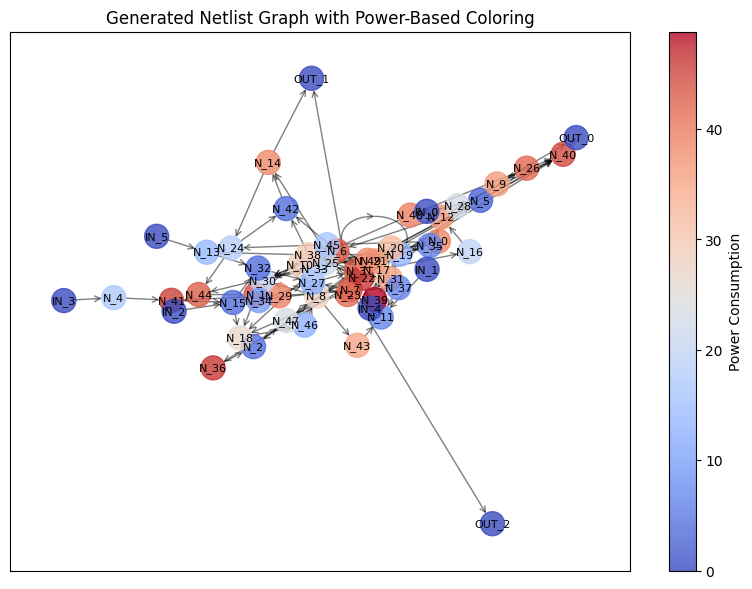

In [ ]:
def visualize_netlist(G):
    pos = nx.spring_layout(G, seed=42)
    power_values = [G.nodes[n].get('power', 0) for n in G.nodes()]

    plt.figure(figsize=(10, 7))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=power_values, cmap='coolwarm', alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.5, arrowstyle='->', arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)

    cbar = plt.colorbar(nodes)
    cbar.set_label("Power Consumption")
    plt.title("Generated Netlist Graph with Power-Based Coloring")
    plt.show()

# Example usage
graph, inputs, outputs = generate_netlist(num_nodes=50, num_edges=100)
visualize_netlist(graph)

In [ ]:
#AGGLOMERATIVE.

import random
from scipy.cluster.hierarchy import linkage, fcluster
import networkx as nx
import numpy as np
from scipy.spatial.distance import pdist, squareform, cityblock, mahalanobis
from scipy.linalg import inv

def calculate_power(G, u, v):
    # This function calculates power consumption for an edge (u, v) in the graph G by considering two factors:
    # 1. Node power: The sum of power consumption of both nodes u and v.
    # 2. Wire Power: The power consumed by the wire connecting u and v, which is product of distance and number of wires

    node_power = G.nodes[u].get('power', 0) + G.nodes[v].get('power', 0)
    wire_power = G.edges[u, v].get('distance', 1) * G.edges[u, v].get('wires', 1)
    return node_power + wire_power

def find_critical_path(G):
    # This function finds the critical path in the graph G based on the longest delay, where the delay is defined as L^2 (distance squared for each edge in the path)
    # This one uses Dijkstra’s Algorithm to find the shortest path from source to target (minimising distance)
    # Computes the delay as the sum of squares of edge distances, then returns the longest delay path and the corresponding maximum delay

    longest_path = None
    max_delay = 0

    for source in G.nodes():
        for target in G.nodes():
            if source != target and nx.has_path(G, source, target):
                path = nx.shortest_path(G, source, target, weight='distance')
                path_delay = sum(G[u][v]['distance'] for u, v in zip(path, path[1:]))
                if path_delay > max_delay:
                    max_delay = path_delay
                    longest_path = path

    return longest_path, max_delay

def perform_agglomerative_clustering(G, num_clusters=5):
    # This function clusters the nodes of a graph G using Agglomerative Clustering, while optimizing based on power and area constraints.
    # Performs Agglomerative Clustering using following methods
    # 1. complete: Merges clusters based on the maximum distance between points in two clusters, ensures tightly bound clusters
    # 2. single: distance between two clusters is defined as the minimum distance between any two points in each cluster, forms long, chain like clusters
    # 3. average: distance between two clusters is the average of all pairwise distances between points in each cluster, tends to produce moderate-sized clusters
    # 4. centroid: distance between two clusters is the distance between their centroids (mean points)
    # 5. ward's linkage: Minimizes the increase in total within-cluster variance when merging two clusters, produces compact, equally sized clusters.

    node_features = []
    node_names = []
    for node in G.nodes():
        power = G.nodes[node].get('power', 0)
        area = G.nodes[node].get('area', 0)
        node_features.append([power, area])
        node_names.append(node)

    node_features = np.array(node_features)

    distance_metric = 'mahalanobis'
    linkage_method = 'single'

    # Computes the pairwise distance matrix based on the selected metric:
    # 1. Cityblock (Manhattan) Distance: Measures the absolute difference between feature values.
    # 2. Mahalanobis Distance: Accounts for correlations between power and area, making clustering more accurate in high-dimensional spaces.

    if distance_metric == 'cityblock':
        dist_matrix = pdist(node_features, metric='cityblock')  # Manhattan Distance
    elif distance_metric == 'mahalanobis':
        VI = inv(np.cov(node_features.T))  # Compute inverse covariance matrix
        dist_matrix = pdist(node_features, metric='mahalanobis', VI=VI)
    else:
        raise ValueError("Unsupported distance metric. Use 'cityblock' or 'mahalanobis'.")

    # Perform hierarchical clustering and assigning cluster labels to each node
    linkage_matrix = linkage(dist_matrix, method=linkage_method)
    clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

    # storing the assigned cluster ID for each node.
    cluster_dict = {node_names[i]: clusters[i] for i in range(len(node_names))}
    nx.set_node_attributes(G, cluster_dict, 'cluster')

    return G, cluster_dict

def calculate_wire_cut_and_length(G, cluster_dict):
    # This function calculates edge cuts and total wire length based on inter-cluster and intra-cluster connections.
    # the wire remains unscaled when its a intra-cluster edge and it gets scaled by 10x to penalize cross-cluster connections when its a inter cluster edge

    edge_cuts, total_wire_length = 0, 0
    scaling_factor = 10

    for u, v, data in G.edges(data=True):
        wire_length = data.get('distance', 1)
        if cluster_dict.get(u) == cluster_dict.get(v):  # Intra-cluster
            total_wire_length += wire_length
        else:  # Inter-cluster
            total_wire_length += scaling_factor * wire_length
            edge_cuts += 1

    return edge_cuts, total_wire_length

def visualize_clusters(G, cluster_dict):
    # this functon visualizes the netlist graph with color-coded clusters.
    # seed = 42 ensures consistent positioning every time you run it.
    pos = nx.spring_layout(G, seed=42)
    cluster_colors = [cluster_dict.get(node, 0) for node in G.nodes()]

    plt.figure(figsize=(10, 7))
    nodes = nx.draw_networkx_nodes(G, pos, node_color=cluster_colors, cmap='tab10', alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.5, arrowstyle='->', arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)

    cbar = plt.colorbar(nodes)
    cbar.set_label("Cluster ID")
    plt.title("Netlist Graph with Clustering")
    plt.show()

Number of Edge Cuts: 59
Total Wire Length: 3275.229999999999
Critical Path Before Scaling: ['N_16', 'N_12', 'N_6', 'N_42', 'N_14', 'N_24', 'N_44', 'N_1', 'N_18', 'N_46', 'N_8', 'N_43', 'N_11', 'N_7', 'N_23', 'N_21', 'N_10', 'N_49']
Critical Path Length Before Scaling: 93.19000000000003
Critical Path After Scaling: ['N_16', 'N_12', 'N_6', 'N_42', 'N_14', 'N_24', 'N_44', 'N_1', 'N_18', 'N_46', 'N_8', 'N_43', 'N_11', 'N_7', 'N_23', 'N_21', 'N_35', 'N_20', 'N_39', 'N_17']
Critical Path Length After Scaling: 602.23


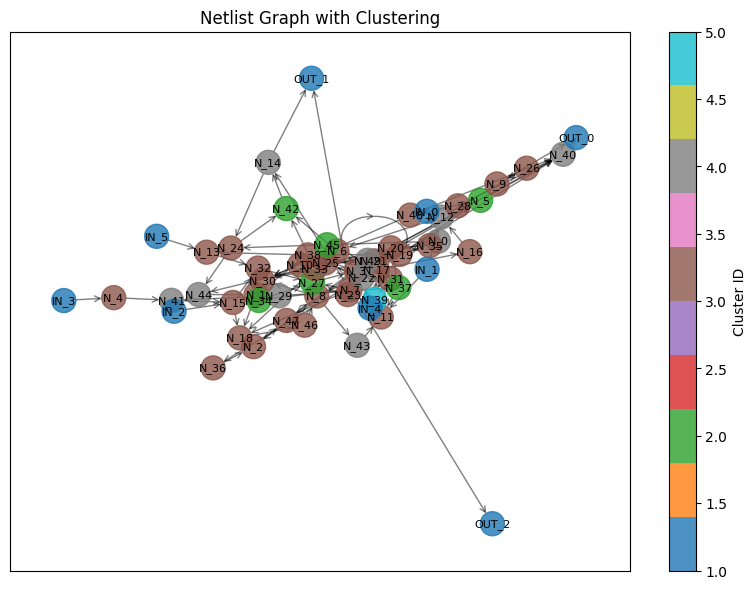

In [ ]:
# Generate the netlist graph
#graph, inputs, outputs = generate_netlist(num_nodes=50, num_edges=100)

# Perform clustering and get the cluster mapping
graph, cluster_dict = perform_agglomerative_clustering(graph)

# Compute edge cuts and wire length
edge_cuts, total_wire_length = calculate_wire_cut_and_length(graph, cluster_dict)

# Compute critical path before scaling
critical_path_before, delay_before = find_critical_path(graph)

# Update distances for inter-cluster edges
for u, v in graph.edges():
    if cluster_dict.get(u) != cluster_dict.get(v):
        graph[u][v]['distance'] *= 10

# Compute critical path after scaling
critical_path_after, delay_after = find_critical_path(graph)

# Print results
print(f"Number of Edge Cuts: {edge_cuts}")
print(f"Total Wire Length: {total_wire_length}")
print(f"Critical Path Before Scaling: {critical_path_before}")
print(f"Critical Path Length Before Scaling: {delay_before}")
print(f"Critical Path After Scaling: {critical_path_after}")
print(f"Critical Path Length After Scaling: {delay_after}")

# Visualize the clusters
visualize_clusters(graph, cluster_dict)

In [ ]:
#KMeans


def separate_disconnected_subgraphs(G):
    """
    Identifies and separates disconnected portions of the graph.

    Parameters:
    - G: A directed graph (DiGraph)

    Returns:
    - List of subgraphs (as NetworkX DiGraphs), where each subgraph is a disconnected portion.
    """
    subgraphs = []

    # Convert to undirected graph to find connected components
    undirected_G = G.to_undirected()

    # Find connected components
    # Using the NetworkX library to check if the undirected graph is connected
    for component in nx.connected_components(undirected_G):
        subgraph = G.subgraph(component).copy()  # Preserve directionality in subgraph
        subgraphs.append(subgraph)

    # Return the library of subgraphs
    return subgraphs


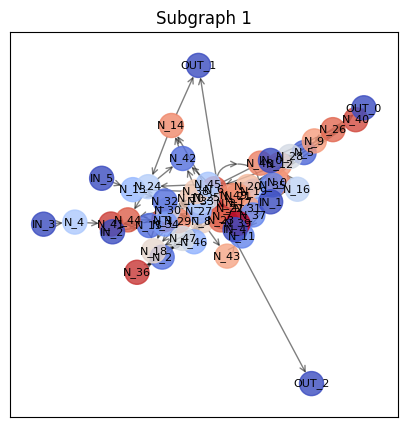

In [ ]:
# Just a visualization
def visualize_disconnected_subgraphs(G):
    subgraphs = separate_disconnected_subgraphs(G)  # Get isolated components
    num_subgraphs = len(subgraphs)

    fig, axes = plt.subplots(1, num_subgraphs, figsize=(5 * num_subgraphs, 5))

    if num_subgraphs == 1:  # Ensure axes is iterable even for one subgraph
        axes = [axes]

    for ax, subG in zip(axes, subgraphs):
        pos = nx.spring_layout(subG, seed=42)  # Layout for consistency
        power_values = [subG.nodes[n].get('power', 0) for n in subG.nodes()]

        nodes = nx.draw_networkx_nodes(subG, pos, node_color=power_values, cmap='coolwarm', alpha=0.8, ax=ax)
        nx.draw_networkx_edges(subG, pos, alpha=0.5, arrowstyle='->', arrows=True, ax=ax)
        nx.draw_networkx_labels(subG, pos, font_size=8, ax=ax)

        ax.set_title(f"Subgraph {subgraphs.index(subG) + 1}")

    plt.show()

visualize_disconnected_subgraphs(graph)


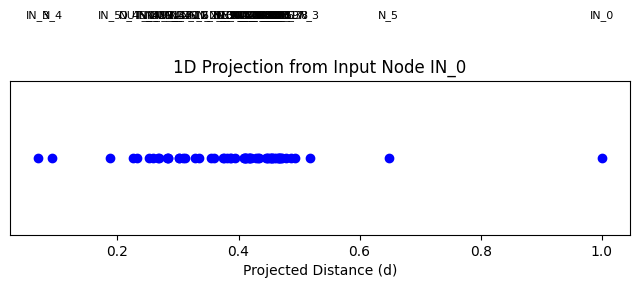

In [ ]:
# Computes the distance metric d = wire_distance * number_of_wires
# This resembles the closeness of two nodes or gates
def compute_edge_weights(G):
    """Modifies G to have a custom distance metric d = wire_distance * num_wires."""
    for u, v in G.edges():
        # Extract edge weights and calculate the custom weights
        wire_distance = G.edges[u, v].get("distance", 1)
        num_wires = G.edges[u, v].get("wires", 1)
        G.edges[u, v]["d"] = wire_distance * num_wires

# Computing paths from the input node
def compute_1d_projection(G, input_node):
    """Computes transformed shortest path distances from an input node to all other nodes."""
    # Convert to undirected graph to allow dijkstra's algorithm
    G_undirected = G.to_undirected()

    # Compute shortest path distances using the custom edge weight
    raw_distances = nx.single_source_dijkstra_path_length(G_undirected, input_node, weight="d")

    # These raw_distances are larger for closely connected nodes
    # So we must find an inverse relationship with the derived metric
    # We choose exp(-dist/mean)
    # Convert distances to ensure closer connections have smaller projected distances
    if len(raw_distances) > 0:
        mean_d = np.mean(list(raw_distances.values()))
        transformed_distances = {node: np.exp(-dist / mean_d) for node, dist in raw_distances.items()}
    else:
        transformed_distances = raw_distances  # If no distances, return as is

    return transformed_distances

# Visualize projection (just for troublehsooting)
def visualize_1d_projection(G, input_node):
    """Visualizes nodes projected onto a 1D line based on distance from input node."""
    distances = compute_1d_projection(G, input_node)

    plt.figure(figsize=(8, 2))

    # Sort nodes based on distance
    sorted_nodes = sorted(distances.items(), key=lambda x: x[1])

    # Plot nodes on a 1D line
    for i, (node, dist) in enumerate(sorted_nodes):
        plt.scatter(dist, 0, color="blue")
        plt.text(dist, 0.1, str(node), fontsize=8, ha="center")

    plt.xlabel("Projected Distance (d)")
    plt.yticks([])  # Remove y-axis
    plt.title(f"1D Projection from Input Node {input_node}")
    plt.show()

# This is important as the input nodes may be divided across subgraphs
def get_valid_input_node(subgraph, input_nodes):
    """Finds a valid input node present in the given subgraph."""
    for node in input_nodes:
        if node in subgraph.nodes():
            return node
    return None  # No input node in this subgraph

# Compute edge weights
compute_edge_weights(graph)

# Get subgraphs
subgraphs = separate_disconnected_subgraphs(graph)

# Find a subgraph with an input node
valid_subgraph = None
valid_input = None

for subgraph in subgraphs:
    valid_input = get_valid_input_node(subgraph, inputs)
    if valid_input:
        valid_subgraph = subgraph
        break  # Stop after finding the first valid subgraph

# Only visualize if we found a valid subgraph and input
if valid_subgraph and valid_input:
    visualize_1d_projection(valid_subgraph, valid_input)
else:
    print("No valid subgraph contains an input node.")


In [ ]:
def apply_kmeans_clustering(projections, num_clusters):
    """Applies K-means clustering on 1D projections"""
    # Randomly initialize cluster centroids from the 1D projection
    centroids = random.sample(list(projections.values()), num_clusters)
    clusters = {i: [] for i in range(num_clusters)}

    for _ in range(100):  # Iterate for convergence
        new_clusters = {i: [] for i in range(num_clusters)}

        # Assign nodes to nearest centroid
        # Also using absolute distance here
        for node, dist in projections.items():
            closest = min(range(num_clusters), key=lambda c: abs(dist - centroids[c]))
            new_clusters[closest].append(node)

        # Recalculate centroids
        # Cluster empty case means the centroid will remain unchanged
        new_centroids = []
        for i in range(num_clusters):
            if new_clusters[i]:
                new_centroids.append(np.mean([projections[n] for n in new_clusters[i]]))
            else:
                # Empty Cluster case
                new_centroids.append(centroids[i])

        # If centroids do not change much, we stop iterations
        if np.allclose(centroids, new_centroids, atol=1e-3):
            break

        # Re-assigning centroids and clusters
        centroids = new_centroids
        clusters = new_clusters

    # Assign cluster labels
    cluster_labels = {}
    for cluster_id, nodes in clusters.items():
        for node in nodes:
            cluster_labels[node] = cluster_id

    return cluster_labels

# Just for visualizing the clustered graph
# Same colour = Same cluster
def visualize_clustered_graph(G, cluster_labels):
    """Visualizes the graph with cluster-based coloring."""
    pos = nx.spring_layout(G, seed=42)
    unique_clusters = set(cluster_labels.values())
    colors = plt.cm.get_cmap("tab10", len(unique_clusters))

    plt.figure(figsize=(10, 7))
    for cluster in unique_clusters:
        nodes = [n for n, c in cluster_labels.items() if c == cluster]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=[colors(cluster)], alpha=0.8)

    nx.draw_networkx_edges(G, pos, alpha=0.5, arrowstyle='->', arrows=True)
    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title("Clustered Netlist Graph")
    plt.show()

# Calculates the optimizations like number of cuts and total wire length
def compute_wire_metrics(G, cluster_labels, input_nodes, output_node):
    """Computes the number of cuts and total wire length."""
    # Number of intercluster wires
    num_cuts = 0
    # Total wirelength, both intra and inter cluster
    total_wire_length = 0

    # Convert G to a directed graph for longest path calculation
    G_weighted = nx.DiGraph()

    for u, v in G.edges():
        wire_length = G.edges[u, v].get("distance", 1)
        cluster_u, cluster_v = cluster_labels.get(u), cluster_labels.get(v)

        if cluster_u == cluster_v:
            edge_weight = wire_length  # Intracluster
        else:
            edge_weight = wire_length * 10  # Intercluster
            num_cuts += 1
            # Note intercluster distances get multiplied by 10

        total_wire_length += edge_weight
        G_weighted.add_edge(u, v, weight=edge_weight)  # Construct weighted graph

    # Remove cycles if any
    while not nx.is_directed_acyclic_graph(G_weighted):
        try:
            cycle = next(nx.simple_cycles(G_weighted))  # Find a cycle
            min_edge = min(
                ((cycle[i], cycle[(i + 1) % len(cycle)]) for i in range(len(cycle))),
                key=lambda e: G_weighted.edges[e].get("weight", 1)
            )
            G_weighted.remove_edge(*min_edge)  # Remove lowest-weight edge
        except StopIteration:
            break

    # Find the critical length (longest path from any input node to output)
    critical_length = 0
    for input_node in input_nodes:
        if input_node in G_weighted.nodes:
            for output_node in output_node:  # Iterate over all output nodes
                if output_node in G_weighted.nodes:
                    try:
                      path = nx.dag_longest_path(G_weighted, weight="weight")
                      path_length = sum(G_weighted[u][v]["weight"] for u, v in zip(path, path[1:]))
                      critical_length = max(critical_length, path_length)
                    except nx.NetworkXNoPath:
                        pass  # No valid path exists for this input-output pair

    return num_cuts, total_wire_length, critical_length

# Calls each method and carries out process from feature extraction to computing results
def Kmeans_1(graph, inputs, outputs):
    """Processes each subgraph, applies K-means, and visualizes clusters."""
    # Calls method to compute edge weights
    compute_edge_weights(graph)
    # Seperate disconnected subgraphs for easier processing on smaller subgraphs
    subgraphs = separate_disconnected_subgraphs(graph)

    #Now, act on each subgraph
    for subgraph in subgraphs:
        #For each subgraph,get an input node
        input_node = get_valid_input_node(subgraph, inputs)
        if not input_node:
            continue  # Skip if no input node

        # Calculate the distance from that input node and then project it onto a 1D space
        projections = compute_1d_projection(subgraph, input_node)
        num_nodes = len(subgraph.nodes())
        # Initializing best_k=2
        best_k = 2
        # Intialize other parameters or test metrics
        best_critical_length = float('inf')
        k_values, cuts, wire_lengths, critical_lengths = [], [], [], []

        # Keeping the minimum number of nodes per cluster to be 5
        for k in range(2, max(2, num_nodes // 5) + 1):
            # Run Kmeans and then calculate the test metrics
            cluster_labels = apply_kmeans_clustering(projections, k)
            num_cuts, total_wire_length, critical_length = compute_wire_metrics(subgraph, cluster_labels, inputs, outputs)

            k_values.append(k)
            cuts.append(num_cuts)
            wire_lengths.append(total_wire_length)
            critical_lengths.append(critical_length)

            if critical_length < best_critical_length:
                best_critical_length = critical_length
                best_k = k

        # This is a bit flawed because obviously, the crtitical length would be quite less if there are no inter-cluster wires
        print(f"Optimal k = {best_k} with Critical Length = {best_critical_length}")
        cluster_labels = apply_kmeans_clustering(projections, best_k)
    return best_critical_length, num_cuts

# Example usage
# Kmeans_1(graph, (inputs), (outputs))



In [ ]:
#Complete Kmeans

In [ ]:
#Spectral Clustering


# Spectral clustering function that takes in graph and number of cluster k
# Returns a node to cluster label mapping
def spectral_clustering_partition(graph, k):
    # Mapping nodes to matrix indices for adjacency matrix construction
    nodes = list(graph.nodes)
    node_index = {node: i for i, node in enumerate(nodes)}
    n = len(nodes)

    # Initialize the affinity matrix
    A = np.zeros((n, n))
    # These can be though of as parameters to compute the distance metric
    # alpha is the wieght for #wires and beta is the weight for distance of wire
    alpha = 1.0
    beta = 1.0

    # Compute normalization term
    sum_vals = []
    for u, v in graph.edges:
        wires = graph[u][v].get('wires', 1)
        dist = graph[u][v].get('distance', 1.0)
        sum_vals.append(alpha*wires + beta*dist)
    mean_sum = np.mean(sum_vals) if sum_vals else 1.0

    # Build affinity matrix
    # A[i][j] = A[j][i] = exp(-(a*wires + b*dist) / mean_sum)
    for u, v in graph.edges:
        i, j = node_index[u], node_index[v]
        wires = graph[u][v].get('wires', 1)
        dist = graph[u][v].get('distance', 1.0)
        affinity = np.exp(-(wires * dist) / mean_sum)
        A[i][j] = A[j][i] = affinity

    # Used spectral clustering function
    clustering = SpectralClustering(n_clusters=k, affinity='precomputed', assign_labels='kmeans', random_state=42)
    labels = clustering.fit_predict(A)

    return {node: labels[i] for node, i in node_index.items()}



In [ ]:
def run_experiment():
    num_nodes = 100
    edge_list = [1000, 1500]  # you can modify this

    results_agg = []
    results_kmeans = []
    results_spectral = []

    for num_edges in edge_list:
        print(f"Running for {num_nodes} nodes and {num_edges} edges...")

        # Generate netlist
        G, input_nodes, output_nodes = generate_netlist(num_nodes, num_edges)

        # Cluster
        G, cluster_dict = perform_agglomerative_clustering(G)

        # Calculate edge cuts and wire length
        edge_cuts, total_wire_length = calculate_wire_cut_and_length(G, cluster_dict)

        # Critical path before scaling
        critical_path_before, delay_before = find_critical_path(G)

        # Scale inter-cluster edges
        for u, v in G.edges():
            if cluster_dict.get(u) != cluster_dict.get(v):
                G[u][v]['distance'] *= 10

        # Critical path after scaling
        critical_path_after, delay_after = find_critical_path(G)

        # Apply Kmeans
        edge_cuts_kmeans, critical_path_kmeans = Kmeans_1(G, input_nodes, output_nodes)

        #Apply Spectral
        k = 5
        cluster_labels = spectral_clustering_partition(graph, k)
        num_cuts_spec, total_wire_length_spec, critical_length_spec = compute_wire_metrics(graph,cluster_labels, inputs, outputs)

        # Store results
        results_agg.append({
            'edges': num_edges,
            'edge_cuts': edge_cuts,
            'critical_path': delay_after
        })

        results_kmeans.append({
            'edges': num_edges,
            'edge_cuts': edge_cuts_kmeans,
            'critical_path': critical_path_kmeans
        })

        results_spectral.append({
            'edges': num_edges,
            'edge_cuts': num_cuts_spec,
            'critical_path': critical_path_kmeans
        })


    # --- NEW PRINTING PART ---
    print("\n=== Agglomerative Clustering Results ===")
    for res in results_agg:
        print(f"Edges: {res['edges']}")
        print(f"Edge Cuts: {res['edge_cuts']}")
        print(f"Critical Path: {res['critical_path']}\n")

    print("\n=== KMeans Clustering Results ===")
    for res in results_kmeans:
        print(f"Edges: {res['edges']}")
        print(f"Edge Cuts: {res['edge_cuts']}")
        print(f"Critical Path : {res['critical_path']}\n")

    print("\n=== Spectral Clustering Results ===")
    for res in results_spectral:
        print(f"Edges: {res['edges']}")
        print(f"Edge Cuts: {res['edge_cuts']}")
        print(f"Critical Path : {res['critical_path']}\n")

# Run the experiment
run_experiment()


Running for 100 nodes and 1000 edges...
Optimal k = 2 with Critical Length = 1931.7800000000002
Running for 100 nodes and 1500 edges...
Optimal k = 2 with Critical Length = 12384.38

=== Agglomerative Clustering Results ===
Edges: 1000
Edge Cuts: 140
Critical Path: 124.35

Edges: 1500
Edge Cuts: 426
Critical Path: 140.78


=== KMeans Clustering Results ===
Edges: 1000
Edge Cuts: 1931.7800000000002
Critical Path : 934

Edges: 1500
Edge Cuts: 12384.38
Critical Path : 1407


=== Spectral Clustering Results ===
Edges: 1000
Edge Cuts: 27
Critical Path : 934

Edges: 1500
Edge Cuts: 27
Critical Path : 1407



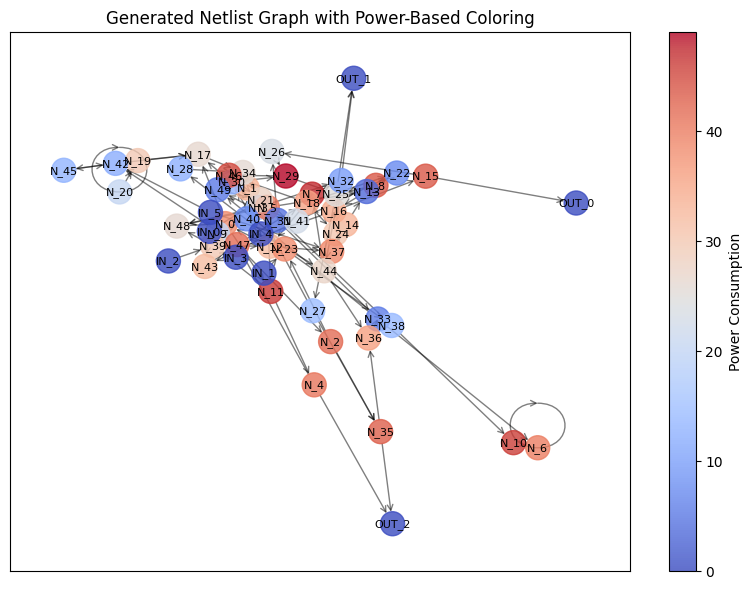

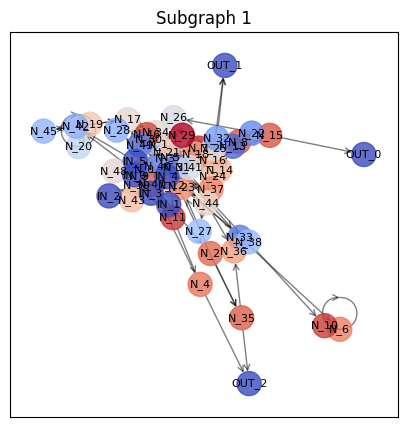

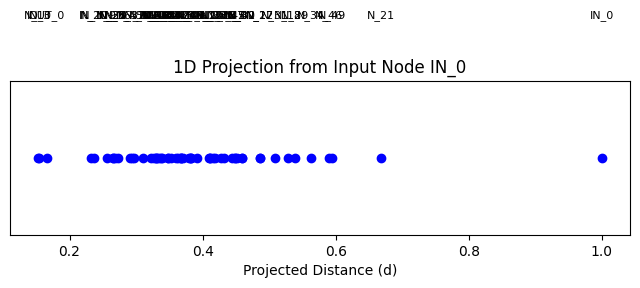

Final: Cuts = 30, Total Wire Length = 1817.5200000000007, Critical Length = 414.29999999999995
Final: Cuts = 43, Total Wire Length = 2582.4300000000003, Critical Length = 458.90999999999997
Final: Cuts = 56, Total Wire Length = 3134.4900000000002, Critical Length = 822.45
Final: Cuts = 62, Total Wire Length = 3457.32, Critical Length = 822.45
Final: Cuts = 70, Total Wire Length = 3666.570000000002, Critical Length = 609.8499999999999
Final: Cuts = 75, Total Wire Length = 3906.6000000000017, Critical Length = 984.02
Final: Cuts = 79, Total Wire Length = 4150.230000000001, Critical Length = 984.02
Final: Cuts = 80, Total Wire Length = 4098.210000000002, Critical Length = 614.8499999999999
Final: Cuts = 84, Total Wire Length = 4229.880000000002, Critical Length = 723.01
Final: Cuts = 85, Total Wire Length = 4307.8200000000015, Critical Length = 800.95


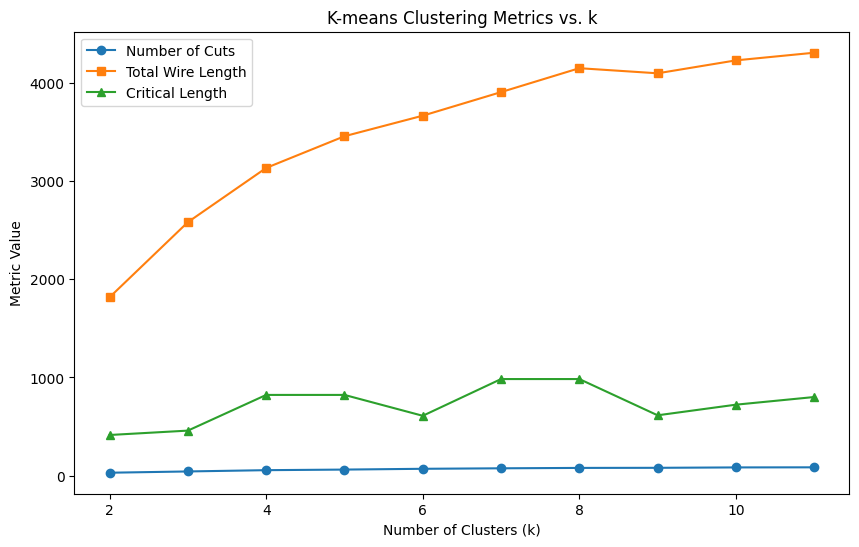

Optimal k = 2 with Critical Length = 414.29999999999995


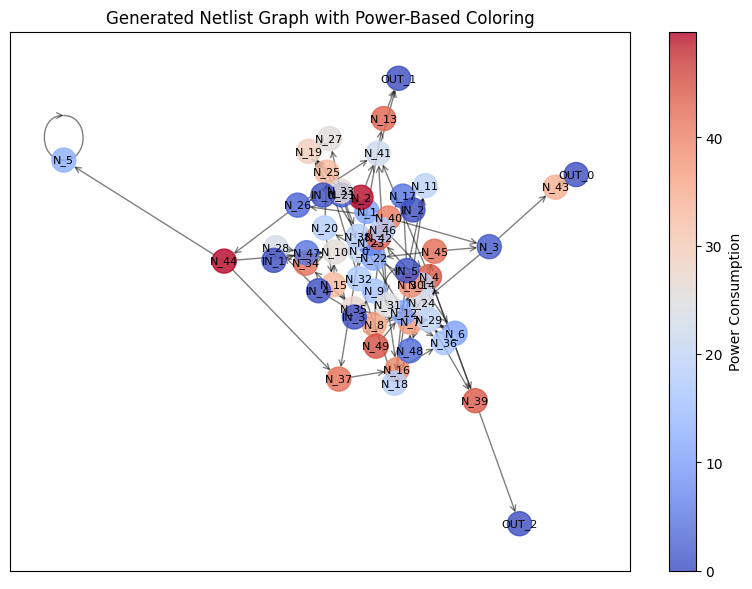

Number of Edge Cuts: 37
Total Wire Length: 2173.74
Critical Path Before Scaling: ['IN_0', 'N_26', 'N_44', 'N_10', 'N_0', 'N_32', 'N_18', 'N_48', 'N_7', 'N_12', 'N_30', 'N_11', 'N_17', 'N_40', 'N_3', 'N_24', 'N_45', 'N_22', 'N_20', 'N_15', 'N_35', 'N_34']
Critical Path Length Before Scaling: 123.72999999999999
Critical Path After Scaling: ['N_27', 'N_19', 'N_25', 'N_21', 'N_0', 'N_32', 'N_18', 'N_48', 'N_7', 'N_12', 'N_30', 'N_11', 'N_17', 'N_40', 'N_3', 'N_43', 'OUT_0']
Critical Path Length After Scaling: 463.73


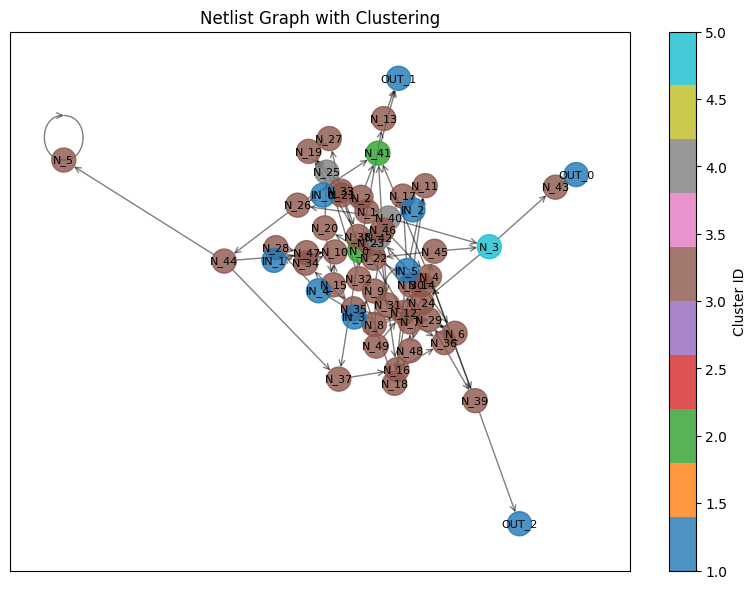

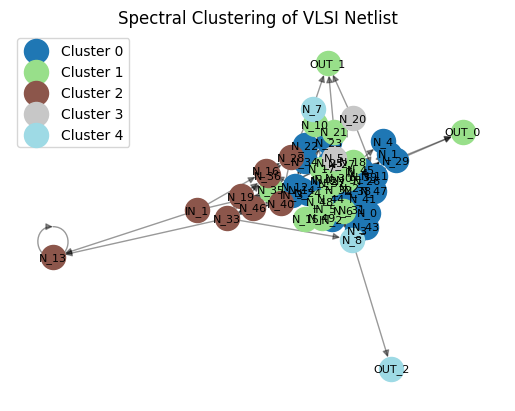

Final: Cuts = 36, Total Wire Length = 2817.51, Critical Length = 997.1300000000001
Spectral Clustering Metrics for k=5:
  - Intercluster Cuts: 36
  - Total Wire Length: 2817.51
  - Critical Path Length (Delay): 997.13


In [ ]:
# # Load the models
# %run Kmeans_1d.ipynb
# %run Aglomerative_cl_1.ipynb
# %run Spectral_cl.ipynb


In [ ]:

# # --------------------- Imports ---------------------
# import networkx as nx
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from tqdm import tqdm

# # Better looking graphs
# sns.set_theme(style="whitegrid")

# # --------------------- Experiment Setup ---------------------

# # MODIFY HERE if needed
# n_nodes = 500  # Number of nodes
# edge_factors = np.arange(2, 10, 1)  # Edge multiplier: 2x to 9x the number of nodes
# edge_list = (edge_factors * n_nodes).astype(int)  # Number of edges list

# # Lists to store results
# kmeans_results = []
# agglo_results = []
# spectral_results = []

# # --------------------- Main Experiment Loop ---------------------
# for n_edges in tqdm(edge_list, desc="Running Experiments"):
#     # Generate a connected graph
#     G = nx.gnm_random_graph(n_nodes, n_edges)
#     while not nx.is_connected(G):
#         G = nx.gnm_random_graph(n_nodes, n_edges)

#     # MODIFY HERE: Make sure these function names match your notebooks
#     G,cluster_dict = perform_agglomerative_clustering(G, num_clusters=5)
#     kmeans_crit_len, kmeans_cuts = calculate_wire_cut_and_length(G,cluster_dict)
#     agglo_crit_len, agglo_cuts = get_agglomerative_results(G)
#     spectral_crit_len, spectral_cuts = get_spectral_results(G)

#     kmeans_results.append((kmeans_crit_len, kmeans_cuts))
#     agglo_results.append((agglo_crit_len, agglo_cuts))
#     spectral_results.append((spectral_crit_len, spectral_cuts))

# # --------------------- Post Processing ---------------------
# # Unpack the results
# kmeans_crit, kmeans_cuts = zip(*kmeans_results)
# agglo_crit, agglo_cuts = zip(*agglo_results)
# spectral_crit, spectral_cuts = zip(*spectral_results)

# # --------------------- Plotting Critical Length ---------------------
# plt.figure(figsize=(12, 6))
# plt.plot(edge_list, kmeans_crit, label='KMeans-1D', marker='o')
# plt.plot(edge_list, agglo_crit, label='Agglomerative', marker='s')
# plt.plot(edge_list, spectral_crit, label='Spectral', marker='^')
# plt.xlabel('Number of Edges')
# plt.ylabel('Critical Length')
# plt.title('Critical Length vs Number of Edges')
# plt.legend()
# plt.grid(True)
# plt.show()

# # --------------------- Plotting Number of Cuts ---------------------
# plt.figure(figsize=(12, 6))
# plt.plot(edge_list, kmeans_cuts, label='KMeans-1D', marker='o')
# plt.plot(edge_list, agglo_cuts, label='Agglomerative', marker='s')
# plt.plot(edge_list, spectral_cuts, label='Spectral', marker='^')
# plt.xlabel('Number of Edges')
# plt.ylabel('Number of Cuts')
# plt.title('Number of Cuts vs Number of Edges')
# plt.legend()
# plt.grid(True)
# plt.show()


Running Experiments:   0%|          | 0/8 [00:20<?, ?it/s]


NameError: name 'get_agglomerative_results' is not defined